In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import sys, os, glob, re, time
import numpy as np
import csv
from collections import Counter
import pickle

# reads tsv edge list where each line is in the format "leftnode rightnode"
# assumes file header contains 'sym' for undirected graph and 'asym' for directed graphs
def convert_tsv_to_graphml(filename):
    m = re.search("(.*)\.tsv", filename)
    name = m.group(1)
    file = open(filename, 'rb')
    header = file.readline()
    print(header)
    if b"asym" in header:
        graph_type = nx.DiGraph()
    else:
        graph_type = nx.Graph()
    lines = [line for line in file if not line.startswith(b"%")]
    print(lines[0], lines[1],"\n")
    g = nx.read_edgelist(lines, create_using=graph_type)
    nx.write_graphml(g, name+".graphml")  
    print(filename)
    return g

def distribution(counts, attribute):
    vals, cnt = zip(*counts.items())
    
    # get rid of all negative values by bumping everything up
    if (np.array(vals) < 0).any():
        print(attribute + " had negative values but is shifted up by {} now".format(-min(vals) + 1))
        vals = np.array(vals) - min(vals) + 1
        
    if 0 in np.array(vals):
        vals = np.array(vals) + 1   # account for possible 0 values for log plot
        print(attribute + " has been shifted up by 1")
        
    fig, ax = plt.subplots()
    plt.scatter(vals, cnt, color='b')
    
    plt.title(attribute + " Plot")
    plt.ylabel("Count")
    plt.xlabel(attribute)
    plt.yscale('log')
    # clustering coefficient only has log plot, not log log
    if attribute == "Clustering Coefficient":
        plt.xscale('linear')
        log_vals = np.log10(vals)
    else:
        plt.xscale('log')
        log_vals = np.log10(vals)
    
    #deg = np.log10(np.array(deg))
    #cnt = np.log10(np.array(cnt))
    vals = np.array(vals)
    cnt = np.array(cnt)
    log_vals = np.log10(vals)
    log_cnt = np.log10(cnt)
    
    m, b = np.polyfit(log_vals, log_cnt, 1)
    y_fit = np.power(10, m*log_vals + b)
    #plt.plot(deg, cnt, '.')
    plt.plot(vals, y_fit , '-')
    
# This will read in the correlation TSV file and create the graphML file to disk
def make_currency_graph(filename):
    corr = np.genfromtxt(fname=filename, delimiter='\t',dtype=float, names=True)    # fname="correlations.tsv"
    corrGraph = nx.Graph()
    names = corr.dtype.names
    
    for i in range(len(corr)):
        l_node = names[i]
        l_type = l_node.split("_")[-1]
        
        for j in range(i, len(corr)):
            r_node = names[j]
            
            if i == 0:
                r_type = r_node.split("_")[-1]
                corrGraph.add_node(l_node, position=l_type)
                corrGraph.add_node(r_node, position=r_type)
                
            corrGraph.add_edge(l_node, r_node, weight = float(corr[i][j]))
    
    corrGraph.name = "currencyCorrelations"
    nx.write_graphml(corrGraph, "currencyCorrelations.graphml")

    return corrGraph

In [6]:
print("START" + "=" * 100 + "START\n\n")
graphs = []

# Find all TSV files and either convert them to GraphML, or read the existing GraphML
for filename in glob.glob("*.tsv"):
    if os.path.exists(filename.replace(".tsv", ".graphml")):
        print(filename.replace(".tsv", ".graphml") + " already exists!")
        g = nx.read_graphml(filename.replace(".tsv", ".graphml"))
    else:
        # Handle currency correlations file differently
        if filename == "currencyCorrelations.tsv":
            g = make_currency_graph(filename)
            print("Handling currencyCorrelations.tsv")
        else:
            g = convert_tsv_to_graphml(filename)
        print("Creating graphml file for", filename)

    g.name = filename.replace(".tsv","")
    print("Graph name is", g.name)

    # Create or retrieve Erdos-Renyi random graph
    if not os.path.exists(g.name + "_ER.graphml"):
        print("Creating ER graph for " + g.name + " from scratch")
        k = 2 * g.number_of_edges() / g.number_of_nodes()   # average degree

        # Use weighted degree for currency graph
        if "currencyCorrelation" in g.name:
            print("For currencies, use weighted degree for ER")
            edges_dict = g.edges()
            k = sum([edges_dict[edge]["weight"] for edge in edges_dict]) * 2 / g.number_of_nodes()

        p = k / (g.number_of_nodes() - 1)                  # probability = avg deg / # of possible neighbors (n-1)
        g_ER = nx.generators.erdos_renyi_graph(g.number_of_nodes(), p)
        nx.write_graphml(g_ER, g.name+"_ER.graphml")
    else:
        print("Reading in the ER graphml file for " + g.name)
        g_ER = nx.read_graphml(g.name+"_ER.graphml")
    g_ER.name = g.name + "_ER"

    # Create or retrieve Barabasi-Albert scale-free network
    if not os.path.exists(g.name + "_BA.graphml"):
        print("Creating BA graph for " + g.name + " from scratch")
        m = 1
        n = g.number_of_nodes()
        g_BA = nx.generators.barabasi_albert_graph(n, m)
        old_dist = abs(g.number_of_edges() - g_BA.number_of_edges())

        # increment m until it generates the BA graph closest to real graph also make sure m never equals n
        while g_BA.number_of_edges() < g.number_of_edges() and m + 1 < n:
            m += 1
            old_dist = abs(g.number_of_edges() - g_BA.number_of_edges())
            g_BA = nx.generators.barabasi_albert_graph(n, m)

        # See how close our graph is to the original and decrement m by 1 if we've gone too far    
        dist = abs(g_BA.number_of_edges() - g.number_of_edges())
        if old_dist < dist:
            g_BA = nx.generators.barabasi_albert_graph(n, m - 1)
            print("Use previous m value:", m - 1)
        else:
            print("Use current m value:", m)

        nx.write_graphml(g_BA, g.name + "_BA.graphml")
    else:
        print("Reading in the BA graphml file for " + g.name)
        g_BA = nx.read_graphml(g.name+"_BA.graphml")
    g_BA.name = g.name + "_BA"    

    graphs += [g, g_ER, g_BA]

START====================================================================================================START


b'BFX_Open\tBFX_High\tBFX_Low\tBFX_Close\tBFX_adjClose\tBFX_volume\tVIX_Open\tVIX_High\tVIX_Low\tVIX_Close\tVIX_adjClose\tVIX_volume\tHSI_Open\tHSI_High\tHSI_Low\tHSI_Close\tHSI_adjClose\tHSI_volume\tRUT_Open\tRUT_High\tRUT_Low\tRUT_Close\tRUT_adjClose\tRUT_volume\tIXIC_Open\tIXIC_High\tIXIC_Low\tIXIC_Close\tIXIC_adjClose\tIXIC_volume\tTWII_Open\tTWII_High\tTWII_Low\tTWII_Close\tTWII_adjClose\tTWII_volume\tGSPC_Open\tGSPC_High\tGSPC_Low\tGSPC_Close\tGSPC_adjClose\tGSPC_volume\tN100_Open\tN100_High\tN100_Low\tN100_Close\tN100_adjClose\tN100_volume\tGDAXI_Open\tGDAXI_High\tGDAXI_Low\tGDAXI_Close\tGDAXI_adjClose\tGDAXI_volume\tNYA_Open\tNYA_High\tNYA_Low\tNYA_Close\tNYA_adjClose\tNYA_volume\tSTOXX50E_Open\tSTOXX50E_High\tSTOXX50E_Low\tSTOXX50E_Close\tSTOXX50E_adjClose\tSTOXX50E_volume\tMXX_Open\tMXX_High\tMXX_Low\tMXX_Close\tMXX_adjClose\tMXX_volume\tAXJO_Open\tAXJO_High\tAXJO_

TypeError: Failed to convert edge data (['0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '1.0', '0.990112980807361', '0.9790523591629198', '0.9635732122472728', '0.9635732122472728', '-0.24761326063144867', '-0.5796333388640164', '-0.5836273714915772', '-0.5830188618987031', '0.45531530852100655', '0.4960456314431391', '0.48065104166549855', '0.4170877073308387', '0.4319112798057434', '0.42559326238221223', '0.47184567429664714', '0.49018945693607063', '0.4823279970695667', '0.47203288297923374', '0.4910591097816409', '0.48342874571672995', '-0.7302832120536016', '-0.7289537399364948', '-0.7295327318259495', '-0.6378158450813837', '-0.649952886922523', '-0.6435158107260248', '-0.6053847077143196', '-0.620632316395695', '-0.6130893891008461', '-0.6075719779565801', '-0.6097469671066522', '-0.6082028415303412', '0.22844789749409858', '0.24525919392995316', '0.23554195048079565', '0.6365391281151935', '0.6427555981429857', '0.6398872415321059', '0.15952049942372784', '0.15661989613460844', '0.15653274920005972', '-0.5231522002104518', '-0.5276129598399112', '-0.5254493702597226', '-0.4635940110123881', '-0.4706675118040633', '-0.4673826027854769', '-0.49515173093119474', '-0.49871868411696446', '-0.49831488864721313', '-0.4888603495393421', '-0.47997559889583796', '-0.48649382207538466', '-0.15131551883158414', '-0.12803186448537787', '-0.1422353255694939', '0.6995797289220195', '0.7114680734812211', '0.7082549790762095', '-0.2656192952701169', '-0.2702721836499238', '-0.2718472610731308', '-0.058358930619260056', '-0.03813990508543901', '-0.04812272248761516', '-0.2603036347710642', '-0.2479046911365645', '-0.2535194378976068', '0.3288827636737595', '0.3545240144729106', '0.3428267624285773', '0.47442246646440145', '0.48922837943475445', '0.4827312783850233', '0.4368830011823378', '0.4504317349845171', '0.4419008724828829', '0.10864477978419768', '0.11749337988894844', '0.11916771530545489', '-0.5337640499652215', '-0.5252254438632366', '-0.5312005982636003', '-0.6794832159461003', '-0.6705706344610992', '-0.6763415063306125', '0.3150189777146108', '0.3494460388372224', '0.332404932293492', '0.5178616976949512', '0.5381703268798537', '0.5324746034438886', '0.5812138657121081', '0.5674258140778047', '0.5794062513333159', '-0.5371331809776971', '-0.5421797250653285', '-0.5404947730847299', '0.5486342067560996', '0.5568214156952094', '0.5525288628070762', '-0.11916064455163096', '-0.11373283317690032', '-0.11684661188095832', '-0.20701920782686595', '-0.14445708708101324', '-0.17435724627558669', '0.5743934630375844', '0.5752824200259606', '0.5713156859928527', '0.3528567423358411', '0.3805219823912524', '0.36506712214269943', '0.4282823434894302', '0.47221678427189623', '0.44566919687093737', '0.1812180129707114', '0.20448169115337028', '0.19557528763796037', '-0.29377217333186034', '-0.28642953070344684', '-0.2930780417881136', '0.7105423316518601', '0.7182339977596222', '0.7153098563220122', '-0.17908517961279946', '-0.19129098860973232', '-0.182796286971399', '-0.6556386351513074', '-0.6629533481676197', '-0.6616739230054741', '-0.7091856643954007', '-0.7123339028517655', '-0.7121451869656341', '-0.3428484193003877', '-0.3371609374516787', '-0.34150338217485443', '0.3032563917677666', '0.30822950128900817', '0.3074522126342101', '0.6336433566513447', '0.6388034808230699', '0.636645421391146', '-0.6638408059522761', '-0.6582424517455061', '-0.6600433933896956', '-0.6985440383264407', '-0.6901708407082234', '-0.6939864226640922', '-0.4291473095611012', '-0.41462976545088953', '-0.42196967564365584', '0.09809297649289946', '0.13318379114363685', '0.11925016691912096', '-0.6547941775889556', '-0.647869764891488', '-0.6522186326591924', '0.7103255399985817', '0.7146363184028515', '0.7123511033386997', '0.4903452968291259', '0.49792107686775167', '0.49522699040265755', '0.5310747330159865', '0.5276595188527324', '0.529182724247776', '0.5509010051296097', '0.551158181997079', '0.5519236699929961', '0.27474650674495976', '0.28405885472878317', '0.28008433791950027', '0.042579354335506435', '0.05024010138927125', '0.04430301633428951', '0.5045659875753263', '0.5253246354018262', '0.5163700266710131', '0.4826661535159587', '0.4873048582341388', '0.48478950564783213', '0.515842661402301', '0.5123446781722779', '0.5138406384154482', '0.5251602437256022', '0.5538759124827645', '0.5366017371573804', '0.4266238488303628', '0.4393520708112761', '0.43406108331249976', '0.6119058906011628', '0.6157473281873208', '0.6139192849311036', '0.5556344877505645', '0.5599047863796385', '0.5562995731311113', '0.706349143782688', '0.7124205472216582', '0.7098907788883292', '0.6777549723758408', '0.6779102689682982', '0.6790729451409544', '-0.6210834232080573', '-0.6188460810646562', '-0.622816121270393']) to dictionary.

In [5]:
# Now loop through all of our graphs
i = 1
for g in graphs:

    graph_name = g.name

    # if we haven't generated the CSV files yet, cut the program off and prompt the user to do so
    if not os.path.exists(graph_name + ".csv"):
        print("We are missing the CSV file of statistics '{}'".format(graph_name + ".csv"))
        print("Now run Gephi statistics on the created GraphML files and export as CSV, then rerun this program")
        continue

    print("\nReading the graph metrics from '" + graph_name + "'.csv")

    statFilCSV = open(graph_name + ".csv", 'r')
    headFile = open(graph_name + ".csv", 'r')
    header = next(csv.reader(headFile))
    headFile.close()

    reader = csv.DictReader(statFilCSV)
    network_stats = {attribute: [] for attribute in header}
    counters = {}

    # Get raw network statistics from CSV Gephi output
    for row in reader:
        Id, label, timeset, eccentricity, closnesscentrality, harmonicclosnesscentrality, betweenesscentrality, componentnumber, degree, clustering, triangles, eigencentrality, weightedDegree \
        = row["Id"], row["Label"],	row["timeset"],	int(row["Eccentricity"]),	float(row["closnesscentrality"]),	float(row["harmonicclosnesscentrality"]),	float(row["betweenesscentrality"]),	int(row["componentnumber"]),	int(row["Degree"]),	float(row["clustering"]),	int(row["triangles"]),	float(row["eigencentrality"]),	float(row["Weighted Degree"])
        network_stats["clustering"].append(clustering)
        network_stats["betweenesscentrality"].append(betweenesscentrality)
        network_stats["Degree"].append(degree)
        network_stats["closnesscentrality"].append(closnesscentrality)
        network_stats["componentnumber"].append(componentnumber)
        network_stats["Weighted Degree"].append(weightedDegree)

    # Get distribution of network statistics
    counters["Degree"] = Counter(sorted(network_stats["Degree"]))
    counters["clustering"] = Counter(sorted(network_stats["clustering"]))
    counters["betweenesscentrality"] = Counter(sorted(network_stats["betweenesscentrality"]))
    counters["closnesscentrality"] = Counter(sorted(network_stats["closnesscentrality"]))
    counters["componentnumber"] = Counter(sorted(network_stats["componentnumber"]))
    counters["Weighted Degree"] = Counter(sorted(network_stats["Weighted Degree"]))

    components = nx.connected_component_subgraphs(g)
    components = sorted(components, key=len, reverse=True)
    network_stats["componentsize"] = [len(comp) for comp in components]
    cc = Counter(network_stats["componentsize"])
    gc = components[0]
    print("Size of largest connected component:", len(gc))
    counters["componentsize"] = cc

    plt.figure(i)
    i += 1

    distribution(counters["Degree"], "Degree")
    plt.suptitle(graph_name)
    if not os.path.exists(graph_name+"-Degree.png"):
        plt.savefig(graph_name+"-Degree.png")
        print("Saving {}-Degree.png".format(graph_name))

    if "currencyCorrelations" in graph_name:
        distribution(counters["Weighted Degree"], "Weighted Degree")
        plt.suptitle(graph_name)
        if not os.path.exists(graph_name+"-WeightedDegree.png"):
            plt.savefig(graph_name+"-WeightedDegree.png")
            print("Saving {}-WeightedDegree.png".format(graph_name))

    if len(set(network_stats["clustering"])) > 1:
        distribution(counters["clustering"], "Clustering Coefficient")
        plt.suptitle(graph_name)
        if not os.path.exists(graph_name+"-ClusteringCoefficient.png"):
            plt.savefig(graph_name+"-ClusteringCoefficient.png")
            print("Saving {}-ClusteringCoefficient.png".format(graph_name))

    if len(set(network_stats["betweenesscentrality"])) > 1:
        distribution(counters["betweenesscentrality"], "Betweeness Centrality")
        plt.suptitle(graph_name)
        if not os.path.exists(graph_name+"-BetweenessCentrality.png"):
            plt.savefig(graph_name+"-BetweenessCentrality.png")
            print("Saving {}-BetweenessCentrality.png".format(graph_name))

    if len(set(network_stats["componentnumber"])) > 1:
        distribution(counters["componentsize"], "Connected Components Size")
        plt.suptitle(graph_name)
        if not os.path.exists(graph_name+"-ConnectedComponents.png"):
            plt.savefig(graph_name+"-ConnectedComponents.png")
            print("Saving {}-ConnectedComponents.png".format(graph_name))

    plt.show()

    print("\nAverage Values:")
    print("\tAverage Degree: {} weighted, {} unweighted".format(np.mean(network_stats["Degree"]), np.mean(network_stats["Weighted Degree"])))
    print("\tAverage Clustering Coefficient:", np.mean(network_stats["clustering"]))
    print("\tAverage Betweeness Centrality:", np.mean(network_stats["betweenesscentrality"]))
    print("\tAverage Connected Components Size:", np.mean(network_stats["componentsize"]))     # since there's only one connected component, average is # of nodes

    print("\nVariance of Values:")
    print("\tVariance of Degree: {} weighted, {} unweighted".format(np.var(network_stats["Degree"]), np.var(network_stats["Weighted Degree"])))
    print("\tVariance of Clustering Coefficient:", np.var(network_stats["clustering"]))
    print("\tVariance of Betweeness Centrality:", np.var(network_stats["betweenesscentrality"]))
    print("\tVariance of Connected Components Size:", np.var(network_stats["componentsize"]))     # since there's only one connected component, variance is 0


    print("Average Closeness Centrality:", np.mean(network_stats["closnesscentrality"]))
    statFilCSV.close()

In [4]:
''' Doing this separately in case it times out'''    
print("=" * 50 + "SHORTEST PATH STUFF" + 50 * "=")
all_lengths = {}
for g in graphs:
    # Skip over computing shortest path lengths if we already outputed the plot file
    if os.path.exists(g.name + "-ShortestPathLengths.png"):
        print("Already computed shortest path lengths stats for", g.name)
        continue

    print("\nGetting shortest path lengths distribution for", g)
    n = g.number_of_nodes()
    lens = []

    t1 = time.time()
    print("Time before all_pairs_shortest_path_length for", g.name + ":", t1)
    lengths = nx.all_pairs_shortest_path_length(g)
    t2 = time.time()
    print("Time after all_pairs_shortest_path_length:", t2)
    print("Elapsed time:", t2-t1)

    t3 = time.time()
    print("Time before iterating through lengths generator:", t3)
    for node, nbrs in lengths:
        lens += list(nbrs.values())

    t4 = time.time()
    print("Time after iterating through lengths generator:", t4)
    print("Elapsed time (should be much longer):", t4-t3)
    print("Average path length (divide by n * (n-1)):", sum(lens) / (n * (n-1)))
    print("Average path length (using np.mean):", np.mean(lens))
    print("Variance of path length:", np.var(lens))
    all_lengths[g.name] = lens

    plt.figure()
    distribution(Counter(sorted(lens)), "Shortest Path Lengths")
    plt.suptitle(g.name)
    if not os.path.exists(g.name+"-ShortestPathLengths.png"):
        plt.savefig(g.name+"-ShortestPathLengths.png")
        print("Saving {}-ShortestPathLengths.png".format(g.name))

if not os.path.exists("shortest_path_lengths.pkl"):
    with open("shortest_path_lengths.pkl", "wb") as lengthsFile:
        pickle.dump(all_lengths, lengthsFile)

print("Done with path lengths")  

print("END" + "=" * 100 + "END\n\n")

==================================================SHORTEST PATH STUFF==================================================
Already computed shortest path lengths stats for currencyCorrelations
Already computed shortest path lengths stats for currencyCorrelations_ER
Already computed shortest path lengths stats for currencyCorrelations_BA
Already computed shortest path lengths stats for ego-facebook
Already computed shortest path lengths stats for ego-facebook_ER
Already computed shortest path lengths stats for ego-facebook_BA
Already computed shortest path lengths stats for moreno_propro_propro
Already computed shortest path lengths stats for moreno_propro_propro_ER
Already computed shortest path lengths stats for moreno_propro_propro_BA
Done with path lengths
END====================================================================================================END




0.0

3

1.8

<Figure size 432x288 with 0 Axes>

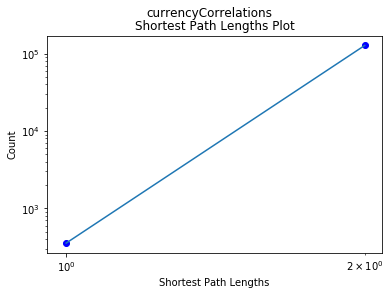

<Figure size 432x288 with 0 Axes>

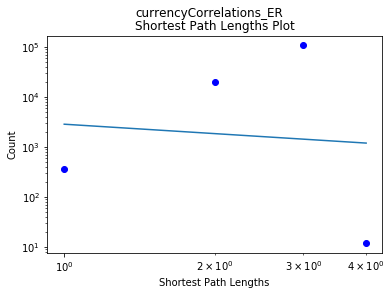

<Figure size 432x288 with 0 Axes>

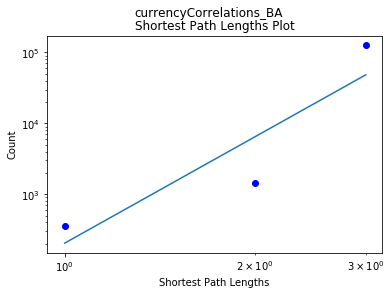

<Figure size 432x288 with 0 Axes>

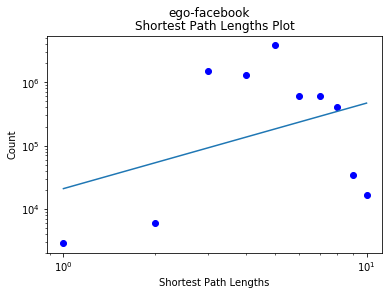

<Figure size 432x288 with 0 Axes>

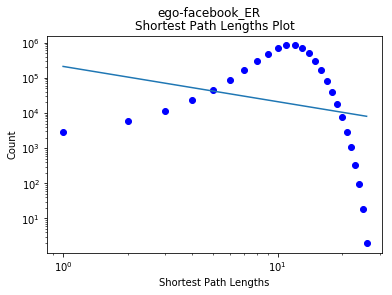

<Figure size 432x288 with 0 Axes>

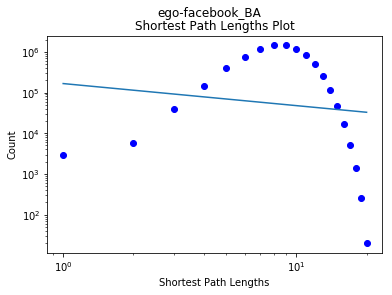

<Figure size 432x288 with 0 Axes>

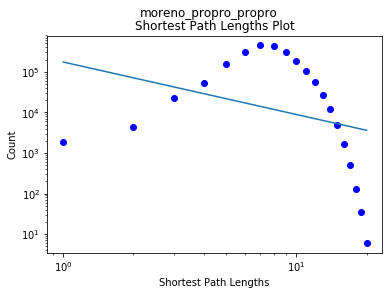

<Figure size 432x288 with 0 Axes>

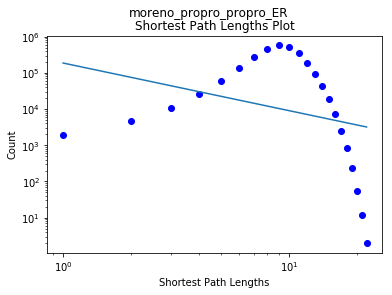

<Figure size 432x288 with 0 Axes>

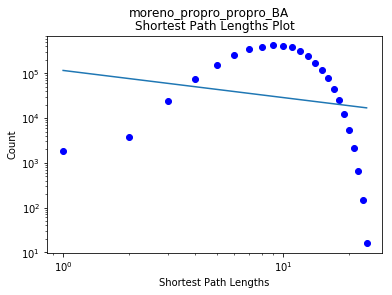

In [115]:
# If you only care about converting currency correlation file to a graph

filename = "correlations.tsv" # change this to correct filename
corrGraph = make_currency_graph(filename)

dict_keys(['currencyCorrelations', 'currencyCorrelations_ER', 'currencyCorrelations_BA', 'ego-facebook', 'ego-facebook_ER', 'ego-facebook_BA', 'moreno_propro_propro', 'moreno_propro_propro_ER', 'moreno_propro_propro_BA'])

56.34878205060191